In [2]:
import torch
from torch import nn
from torchvision import transforms as T
from PIL import Image
import numpy as np
from pathlib import Path
from collections import deque
import random, datetime, os, copy

# Gym is an OpenAI toolkit for RL
import gym
from gym.spaces import Box
from gym.wrappers import FrameStack

# NES Emulator for OpenAI Gym
from nes_py.wrappers import JoypadSpace

# Super Mario environment for OpenAI Gym
import gym_super_mario_bros
from gym_super_mario_bros.actions import RIGHT_ONLY

#tqdm
import tqdm

import matplotlib.pyplot as plt
import time


## Preprocessing the environment

In [3]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, trunk, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, trunk, info

    
class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation

class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transforms = T.Compose(
            [T.Resize(self.shape), T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0)
        return observation


def generate_env(env):
   # Apply Wrappers to environment
    env = SkipFrame(env, skip=4)
    env = GrayScaleObservation(env)
    env = ResizeObservation(env, shape=84)
    if gym.__version__ < '0.26':
        env = FrameStack(env, num_stack=4, new_step_api=True)
    else:
        env = FrameStack(env, num_stack=4)
    return JoypadSpace(env, RIGHT_ONLY)

In [4]:
#env = generate_env(gym_super_mario_bros.make('SuperMarioBros-1-1-v3', apply_api_compatibility=True))#, render_mode="human"))
# print(env.observation_space
# print(env.observation_space.shape)
# print(env.action_space.n)
# print(env.action_space)


# done = True
# env.reset()
# print('---------------------------------------------------------------')
# for step in range(1):
#     action = env.action_space.sample()
#     obs, reward, terminated, truncated, info = env.step(action)
#     print(type(obs))
#     print(f"main: {obs.shape}, {type(obs)}")
#     done = terminated or truncated
#     if done:
#        state = env.reset()

# env.close()

## Defining a Convolutional Deep Q network



In [5]:
# customized weight initialization
def customized_weights_init(m):
    # compute the gain
    gain = nn.init.calculate_gain('relu')
    # init the convolutional layer
    if isinstance(m, nn.Conv2d):
        # init the params using uniform
        nn.init.xavier_uniform_(m.weight, gain=gain)
        nn.init.constant_(m.bias, 0)
    # init the linear layer
    if isinstance(m, nn.Linear):
        # init the params using uniform
        nn.init.xavier_uniform_(m.weight, gain=gain)
        nn.init.constant_(m.bias, 0)

In [6]:
class DeepQNet(nn.Module):
    """mini cnn structure
  input -> (conv2d + relu) x 3 -> flatten -> (dense + relu) x 2 -> output
  """

    def __init__(self, input_dim, output_dim):
        super().__init__()
        c, h, w = input_dim

        if h != 84:
            raise ValueError(f"Expecting input height: 84, got: {h}")
        if w != 84:
            raise ValueError(f"Expecting input width: 84, got: {w}")

        self.ConvNet = nn.Sequential(
            nn.Conv2d(in_channels=c, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )
    
    def forward(self, input):
        return self.ConvNet(input)

## Define a Experience Replay Buffer

One main contribution of DQN is proposing to use the replay buffer. Here is the implementation of a simple replay buffer as a list of transitions (i.e., [(s, a, r, s', d), ....]). 

In [7]:
class ReplayBuffer(object):
    """ Implement the Replay Buffer as a class, which contains:
            - self._data_buffer (list): a list variable to store all transition tuples.
            - add: a function to add new transition tuple into the buffer
            - sample_batch: a function to sample a batch training data from the Replay Buffer
    """
    def __init__(self, buffer_size):
        """Args:
               buffer_size (int): size of the replay buffer
        """
        # total size of the replay buffer
        self.buffer_size = buffer_size
        #self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.device = torch.device('cuda')


        # create a list to store the transitions
        self._data_buffer = deque(maxlen=self.buffer_size)

    def add(self, obs, act, reward, next_obs, done):
        
        #Converting observations to tensors
        obs = obs[0].__array__() if isinstance(obs, tuple) else obs.__array__()
        next_obs = next_obs[0].__array__() if isinstance(next_obs, tuple) else next_obs.__array__()

        obs = torch.tensor(obs, device=self.device)
        next_obs = torch.tensor(next_obs, device=self.device)
        act = torch.tensor([act], device=self.device)
        reward = torch.tensor([reward], dtype=torch.float32, device=self.device)
        done = torch.tensor([done], dtype=torch.float32, device=self.device)

        # Saving the tuple to memory
        self._data_buffer.append((obs, act, reward, next_obs, done))

    def sample_batch(self, batch_size):
        """ Args:
                batch_size (int): size of the sampled batch data.
        """
        #Sample a batch from memory
        batch = random.sample(self._data_buffer, batch_size)
        #Stack the batch into tensors
        obs, act, reward, next_obs, done = map(torch.stack, zip(*batch))

        #Unsqueezed
        return obs, act, reward, next_obs, done

## Define a schedule for epsilon-greedy policy

Here, we define a schedule function to return the epsilon for each time step t. 

In [8]:
class LinearSchedule(object):
    """ This schedule returns the value linearly"""
    def __init__(self, start_value, end_value, duration):
        # start value
        self._start_value = start_value
        # end value
        self._end_value = end_value
        # time steps that value changes from the start value to the end value
        self._duration = duration
        # difference between the start value and the end value
        self._schedule_amount = end_value - start_value

    def get_value(self, time):
        # logic: if time > duration, use the end value, else use the scheduled value
        """ CODE HERE: return the epsilon for each time step within the duration.
        """
        if time > self._duration:
            return self._end_value
        return self._start_value + (self._schedule_amount/self._duration)*time
        

## Run experiment (DQN)

In [9]:
def plot_curves_return(arr_list, legend_list, color_list, ylabel, fig_title):
    """
    Args:
        arr_list (list): list of results arrays to plot
        legend_list (list): list of legends corresponding to each result array
        color_list (list): list of color corresponding to each result array
        ylabel (string): label of the Y axis

        Note that, make sure the elements in the arr_list, legend_list and color_list are associated with each other correctly.
        Do not forget to change the ylabel for different plots.
    """
    # set the figure type
    fig, ax = plt.subplots(figsize=(12, 8))

    # PLEASE NOTE: Change the labels for different plots
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Episodes")

    # ploth results
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        # compute the standard error
        arr_err = arr.std(axis=0) / np.sqrt(arr.shape[0])
        # plot the mean
        h, = ax.plot(range(arr.shape[1]), arr.mean(axis=0), color=color, label=legend)
        # plot the confidence band
        arr_err *= 1.96
        ax.fill_between(range(arr.shape[1]), arr.mean(axis=0) - arr_err, arr.mean(axis=0) + arr_err, alpha=0.3,
                        color=color)
        # save the plot handle
        h_list.append(h)

    # plot legends
    ax.set_title(f"{fig_title}")
    ax.legend(handles=h_list)

    plt.show()

In [10]:
def plot_curves_loss(arr_list, legend_list, color_list, ylabel, fig_title):
    """
    Args:
        arr_list (list): list of results arrays to plot
        legend_list (list): list of legends corresponding to each result array
        color_list (list): list of color corresponding to each result array
        ylabel (string): label of the Y axis

        Note that, make sure the elements in the arr_list, legend_list and color_list are associated with each other correctly.
        Do not forget to change the ylabel for different plots.
    """
    # set the figure type
    fig, ax = plt.subplots(figsize=(12, 8))

    # PLEASE NOTE: Change the labels for different plots
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Time Steps")

    # ploth results
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        # compute the standard error
        arr_err = arr.std(axis=0) / np.sqrt(arr.shape[0])
        # plot the mean
        h, = ax.plot(range(arr.shape[1]), arr.mean(axis=0), color=color, label=legend)
        # plot the confidence band
        arr_err *= 1.96
        ax.fill_between(range(arr.shape[1]), arr.mean(axis=0) - arr_err, arr.mean(axis=0) + arr_err, alpha=0.3,
                        color=color)
        # save the plot handle
        h_list.append(h)

    # plot legends
    ax.set_title(f"{fig_title}")
    ax.legend(handles=h_list)
 
    plt.show()

 #  Super Mario DDQN
 
In this question, we will exam our implementation in two classic control tasks in gym. Due to the slight difference between the action spaces of the FourRooms and the CartPole/LunarLander, we have to modify the DQNAgent and the training function a little bit. But, you do NOT have to modify the code according to such change. Just complete the code as previously. 

In [11]:
class DQNAgent(object):
    # initialize the agent
    def __init__(self,
                 params,
                 ):
        # save the parameters
        self.params = params

        # environment parameters
        self.action_dim = params['action_dim']
        self.obs_dim = params['observation_dim']

        # executable actions
        self.action_space = params['action_space']

        # create behavior policy network
        self.behavior_policy_net = DeepQNet(input_dim=params['observation_dim'],
                                            output_dim=params['action_dim'])
        # create target network
        self.target_policy_net = DeepQNet(input_dim=params['observation_dim'],
                                          output_dim=params['action_dim'])

        # initialize target network with behavior network
        self.behavior_policy_net.apply(customized_weights_init)
        self.target_policy_net.load_state_dict(self.behavior_policy_net.state_dict())

        # send the agent to a specific device: cpu or gpu
        self.device = torch.device('cuda')
        #self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.behavior_policy_net.to(self.device)
        self.target_policy_net.to(self.device)

        # optimizer
        self.optimizer = torch.optim.Adam(self.behavior_policy_net.parameters(), lr=params['learning_rate'])

    # get action
    def get_action(self, obs, eps):
        if np.random.random() < eps:  # with probability eps, the agent selects a random action
            action = self.action_space.sample()
        else:  # with probability 1 - eps, the agent selects a greedy policy
            obs = obs[0].__array__() if isinstance(obs, tuple) else obs.__array__()
            obs = torch.tensor(obs, device=self.device).unsqueeze(0)
            with torch.no_grad():
                q_values = self.behavior_policy_net(obs)
                action = torch.argmax(q_values, axis=1).item()
        return action

    # update behavior policy
    def update_behavior_policy(self, batch_data):
        # get batch data 
        obs_tensor, actions_tensor, rewards_tensor, next_obs_tensor, dones_tensor = batch_data
        
        """CODE HERE:
                Compute the predicted Q values using the behavior policy network
        """
        # compute the q value estimation using the behavior network
        q_values = self.behavior_policy_net(obs_tensor)
        q_tensor = torch.gather(q_values , 1, actions_tensor)
        
        # compute the TD target using the target network
        q_prime_values = self.target_policy_net(next_obs_tensor)
        target_tensor = rewards_tensor + (torch.max(q_prime_values, 1, keepdim=True)[0]*self.params['gamma']*(1-dones_tensor))
    
        # compute the loss
        loss_fn = torch.nn.MSELoss() 
        td_loss = loss_fn(q_tensor, target_tensor)  
        
        # minimize the loss
        self.optimizer.zero_grad()
        td_loss.backward()
        self.optimizer.step()

        return td_loss.item()

    # update update target policy
    def update_target_policy(self):
        # hard update
        """CODE HERE: 
                Copy the behavior policy network to the target network
        """
        self.target_policy_net.load_state_dict(self.behavior_policy_net.state_dict())
        
    # load trained model
    def load_model(self, model_file):
        # load the trained model
        self.behavior_policy_net.load_state_dict(torch.load(model_file, map_location=self.device))
        self.behavior_policy_net.eval()



In [12]:
def train_dqn_agent(env, params):
    # create the DQN agent
    my_agent = DQNAgent(params)

    # create the epsilon-greedy schedule
    my_schedule = LinearSchedule(start_value=params['epsilon_start_value'],
                                 end_value=params['epsilon_end_value'],
                                 duration=params['epsilon_duration'])

    # create the replay buffer
    replay_buffer = ReplayBuffer(params['replay_buffer_size'])

    # training variables
    episode_t = 0
    rewards = []
    train_returns = []
    undiscounted_reward = []
    loss = 0

    # reset the environment
    obs = env.reset()

    # start training
    pbar = tqdm.trange(params['total_training_time_step'])
    last_best_return = 0
    for t in pbar:
        # scheduled epsilon at time step t
        eps_t = my_schedule.get_value(t)
        # get one epsilon-greedy action
        action = my_agent.get_action(obs, eps_t)

        # step in the environment
        next_obs, reward, done, _, _ = env.step(action)

        # add to the buffer
        replay_buffer.add(obs, action, reward, next_obs, done)
        rewards.append(reward)

        # check termination
        if done or episode_t == params['max_time_step_per_episode'] - 1:
            # compute the return
            G = 0
            R = 0
            for r in reversed(rewards):
                R += r
                G = r + params['gamma'] * G

            if G > last_best_return:
                torch.save(my_agent.behavior_policy_net.state_dict(), f"./{params['model_name']}")

            # store the return
            train_returns.append(G)
            undiscounted_reward.append(R)
            episode_idx = len(train_returns)

            # print the information
            pbar.set_description(
                f"Ep={episode_idx} | "
                f"G={np.mean(train_returns[-10:]) if train_returns else 0:.2f} | "
                f"Eps={eps_t}"
            )

            # reset the environment
            episode_t, rewards = 0, []
            obs = env.reset()
        else:
            # increment
            obs = next_obs
            episode_t += 1

        if t > params['start_training_step']:
            # update the behavior model
            if not np.mod(t, params['freq_update_behavior_policy']):
                """ CODE HERE:
                    Update the behavior policy network
                """
                batch_data = replay_buffer.sample_batch(params['batch_size'])
                my_agent.update_behavior_policy(batch_data)

            # update the target model
            if not np.mod(t, params['freq_update_target_policy']):
                """ CODE HERE:
                    Update the behavior policy network
                """
                my_agent.update_target_policy()
                
    # save the results
    return train_returns, undiscounted_reward

In [13]:
if __name__ == '__main__':
    # create environment
    my_env = generate_env(gym_super_mario_bros.make('SuperMarioBros-1-1-v3', apply_api_compatibility=True))#, render_mode="human"))

    # create training parameters
    train_parameters = {
        'observation_dim': my_env.observation_space.shape,
        'action_dim': my_env.action_space.n,
        'action_space': my_env.action_space,
        'gamma': 0.99,
        
        'max_time_step_per_episode': 500,

        'total_training_time_step': 3_000_000,#1_000_000,

        'epsilon_start_value': 1.0,
        'epsilon_end_value': 0.01,
        'epsilon_duration': 2_500_000, 

        'replay_buffer_size': 30_000, 
        'start_training_step': 50,
        'freq_update_behavior_policy': 5,
        'freq_update_target_policy': 5000, 

        'batch_size': 32, 
        'learning_rate': 0.00025,

        'model_name': "mario.pt"
    }


    # create experiment
    train_returns, undiscounted_reward = train_dqn_agent(my_env, train_parameters)


NameError: name 'dasdsa' is not defined

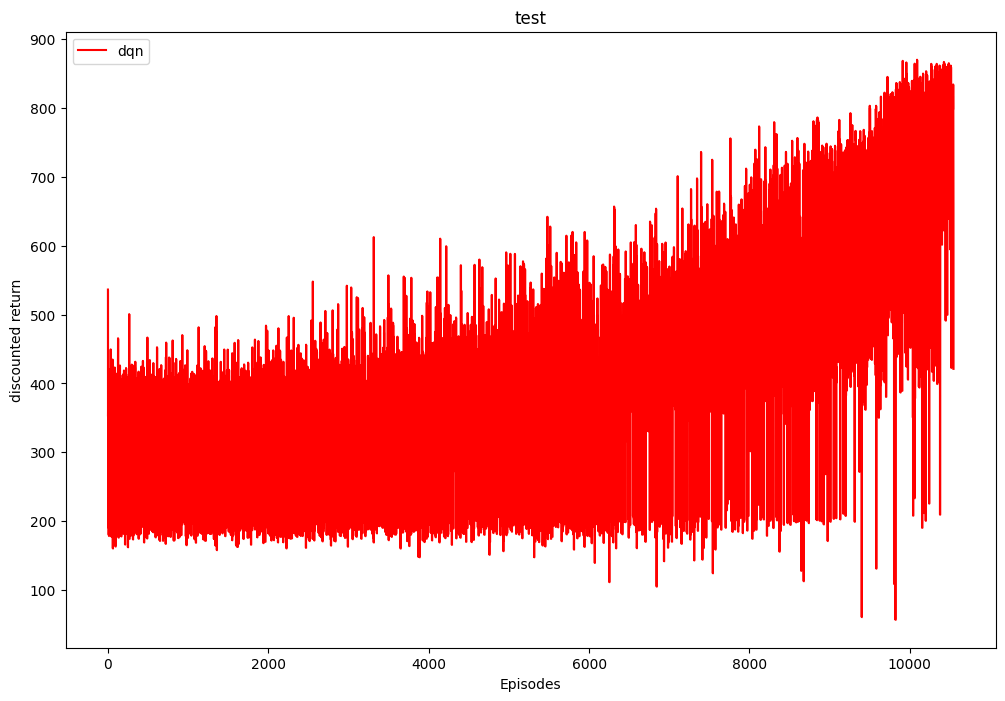

In [ ]:
plot_curves_return([np.array([train_returns])], ['dqn'], ['r'], 'discounted return', 'test')

In [ ]:
import pickle
with open('returns_dqn.pk1', 'wb') as file:
    pickle.dump(train_returns, file)

with open('rewards_dqn.pk1', 'wb') as file:
    pickle.dump(undiscounted_reward, file)


In [21]:
#Run DQN and DDQN for 1000 episodes
if __name__ == '__main__':
    # create environment
    my_env = generate_env(gym_super_mario_bros.make('SuperMarioBros-1-1-v3', apply_api_compatibility=True))#, render_mode="human"))

    # create training parameters
    train_parameters = {
        'observation_dim': my_env.observation_space.shape,
        'action_dim': my_env.action_space.n,
        'action_space': my_env.action_space,
        'gamma': 0.99,
        
        'max_time_step_per_episode': 500,

        'total_training_time_step': 3_000_000,#1_000_000,

        'epsilon_start_value': 1.0,
        'epsilon_end_value': 0.01,
        'epsilon_duration': 2_500_000, 

        'replay_buffer_size': 30_000, 
        'start_training_step': 50,
        'freq_update_behavior_policy': 5,
        'freq_update_target_policy': 5000, 

        'batch_size': 32, 
        'learning_rate': 0.00025,

        'model_name': "mario.pt"
    }

    agent = DQNAgent(train_parameters)
    agent.load_model("mariodqn.pt")

    gamma = 0.99
    step_list = []
    undisc_returns = []
    returns = []
    for i in range(1000):
        state = my_env.reset()
        step_count = 0
        done = False
        ep_reward = []
        R = 0
        G = 0
        while not done:
            action = agent.get_action(state, 0.1)
            next_obs, reward, done, _, info = my_env.step(action)
            flag = info['flag_get']
            ep_reward.append(reward)
            step_count+= 1
            state = next_obs
        if flag:
            for r in reversed(ep_reward):
                R += r
                G  = r + gamma*G
            undisc_returns.append(R)
            returns.append(G)
            step_list.append(step_count)


In [22]:
import pickle
with open('trained_returns_dqn.pk1', 'wb') as file:
    pickle.dump(returns, file)

with open('undisc_trained_returns_dqn.pk1', 'wb') as file:
    pickle.dump(undisc_returns, file)

with open('step_count_dqn.pk1', 'wb') as file:
    pickle.dump(step_list, file)